In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns

In [2]:
sample = pd.read_csv('/home/kumarv/tayal007/GeoTiff/Min/sample_submission_v2.csv/sample_submission_v2.csv')
print(sample.shape)
sample.head()

(61191, 2)


image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

In [3]:
df = pd.read_csv('/home/kumarv/tayal007/GeoTiff/Min/train_v2.csv/train_v2.csv')
print (df.head())
print (df.shape)

  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road
(40479, 2)


In [4]:
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [5]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

tag      0
12      primary  37513
5         clear  28431
0   agriculture  12315
13         road   8071
16        water   7411

In [6]:
print (type(tags_counted_and_sorted))
print (tags_counted_and_sorted.dtypes)
tags_counted_and_sorted

<class 'pandas.core.frame.DataFrame'>
tag    object
0       int64
dtype: object


tag      0
12            primary  37513
5               clear  28431
0         agriculture  12315
13               road   8071
16              water   7411
11      partly_cloudy   7261
8         cultivation   4547
9          habitation   3660
10               haze   2697
6              cloudy   2089
2         bare_ground    862
14  selective_logging    340
1      artisinal_mine    339
3            blooming    332
15         slash_burn    209
4           blow_down    101
7   conventional_mine    100

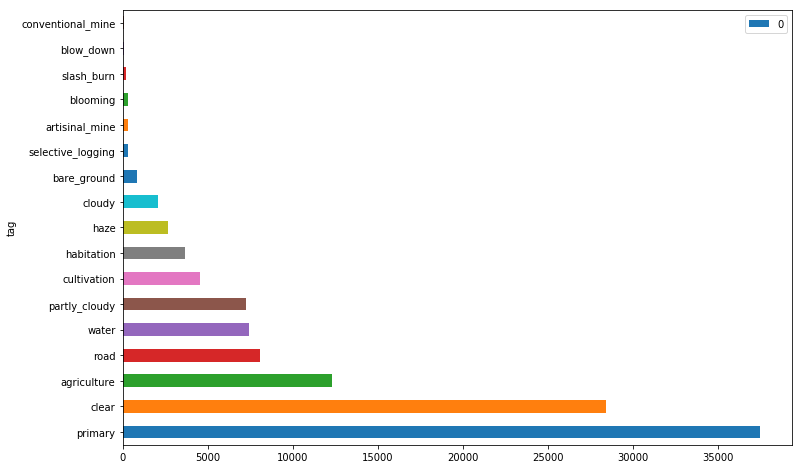

In [7]:
tags_counted_and_sorted.plot.barh(x="tag", y=0, figsize=(12,8))

In [8]:
tag_probas = tags_counted_and_sorted[0].values/tags_counted_and_sorted[0].values.sum()
indicators = np.hstack([bernoulli.rvs(p, 0, sample.shape[0]).reshape(sample.shape[0], 1) for p in tag_probas])
indicators = np.array(indicators)
indicators.shape

(61191, 17)

In [9]:
sorted_tags = tags_counted_and_sorted['tag'].values
all_test_tags = []
for index in range(indicators.shape[0]):
    all_test_tags.append(' '.join(list(sorted_tags[np.where(indicators[index, :] == 1)[0]])))
len(all_test_tags)

61191

In [10]:
sample['tags'] = all_test_tags
sample.head()

image_name                    tags
0     test_0             agriculture
1     test_1  clear agriculture road
2     test_2       clear agriculture
3     test_3             agriculture
4     test_4             agriculture

In [11]:
sample.to_csv('bernoulli_submission.csv', index=False)

In [12]:
from glob import glob
image_paths = sorted(glob('/home/kumarv/tayal007/GeoTiff/Min/train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

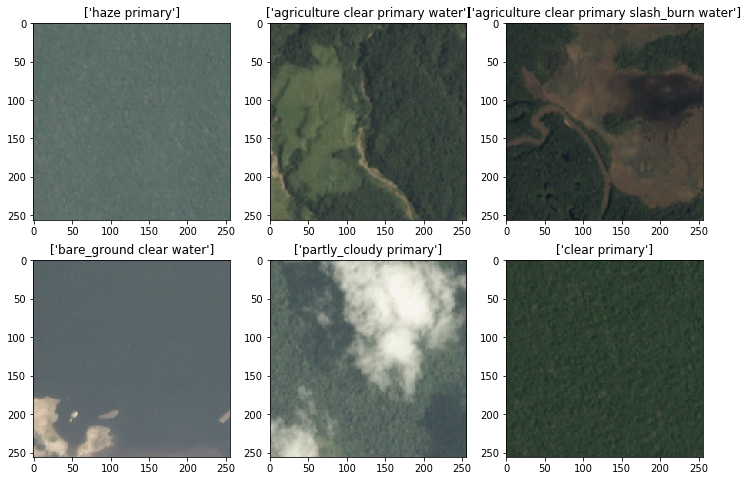

In [13]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings

n_samples = 5000
rescaled_dim = 20

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]
X = np.squeeze(np.array([cv2.resize(plt.imread('/home/kumarv/tayal007/GeoTiff/Min/train-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)

print(X.shape, y.shape, lb.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf.fit(X_train, y_train)

score = fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

/home/kumarv/tayal007/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(5000, 1600) (5000, 17) ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']
Average F2 test score 0.6915805409891536
F2 test scores per tag:


/home/kumarv/tayal007/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kumarv/tayal007/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[('primary', 0.9655718242975863),
 ('clear', 0.8906708053112607),
 ('cloudy', 0.603112840466926),
 ('agriculture', 0.376940133037694),
 ('road', 0.30851777330650565),
 ('partly_cloudy', 0.20510835913312692),
 ('water', 0.20149253731343283),
 ('habitation', 0.14218009478672985),
 ('artisinal_mine', 0.07142857142857144),
 ('cultivation', 0.04559270516717326),
 ('bare_ground', 0.03012048192771084),
 ('haze', 0.02824858757062147),
 ('slash_burn', 0.0),
 ('conventional_mine', 0.0),
 ('selective_logging', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0)]

In [15]:
import cv2

n_imgs = 600

all_imgs = []

for i in range(n_imgs):
    img = plt.imread(image_paths[i])
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    all_imgs.append(img)

img_mat = np.vstack(all_imgs)
img_mat.shape

(600, 40000)

(600, 600)


/home/kumarv/tayal007/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/kumarv/tayal007/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



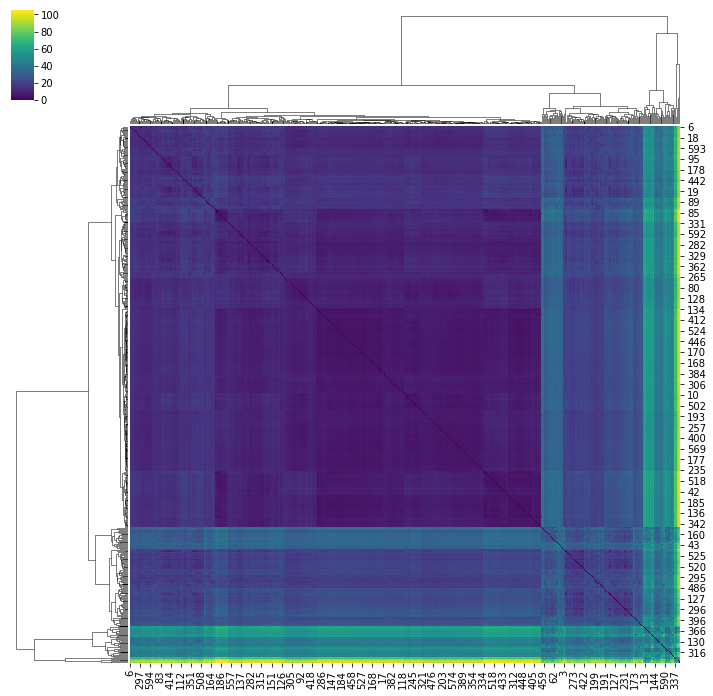

In [47]:
from scipy.spatial.distance import pdist, squareform

sq_dists = squareform(pdist(img_mat))
print(sq_dists.shape)
sns.clustermap(
    sq_dists,
    figsize=(12,12),
    cmap=plt.get_cmap('viridis')
)

In [23]:
img_mat.shape

(600, 40000)

In [17]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.476s...
[t-SNE] Computed neighbors for 600 samples in 28.420s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 2.026685
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 97.9050217, gradient norm = 0.2330765 (50 iterations in 1.559s)
[t-SNE] Iteration 100: error = 112.9229965, gradient norm = 0.1681537 (50 iterations in 1.477s)
[t-SNE] Iteration 150: error = 118.4972000, gradient norm = 0.1550066 (50 iterations in 1.430s)
[t-SNE] Iteration 200: error = 123.3423386, gradient norm = 0.1496353 (50 iterations in 1.461s)
[t-SNE] Iteration 250: error = 126.5430984, gradient norm = 0.1241635 (50 iterations in 1.415s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 126.543098
[t-SNE] Iteration 300: error = 4.3612361, gradient norm = 0.0006650 (50 iterations in 1.617s)
[t-SNE] Iteration 350: error = 3.7498093, gradient norm = 0.000

In [19]:
tsne.shape

(600, 3)

In [20]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        #color = preprocessing.LabelEncoder().fit_transform(all_image_types),
        #colorscale = 'Portland',
        #colorbar = dict(title = 'images'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.9
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3D embedding of images')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

Text(0.5,1,'maximally similar')

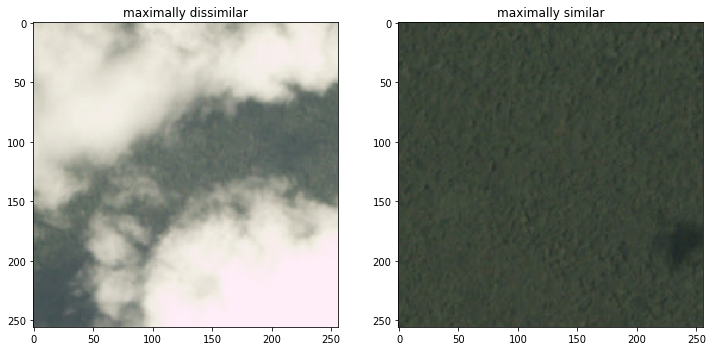

In [48]:
#mask = np.zeros_like(sq_dists, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# upper triangle of matrix set to np.nan
#sq_dists[np.triu_indices_from(mask)] = np.nan
#sq_dists[0, 0] = np.nan

fig = plt.figure(figsize=(12,8))
# maximally dissimilar image
ax = fig.add_subplot(1,2,1)
maximally_dissimilar_image_idx = np.nanargmax(np.nanmean(sq_dists, axis=1))
plt.imshow(plt.imread(image_paths[maximally_dissimilar_image_idx]))
plt.title('maximally dissimilar')

# maximally similar image
ax = fig.add_subplot(1,2,2)
maximally_similar_image_idx = np.nanargmin(np.nanmean(sq_dists, axis=1))
plt.imshow(plt.imread(image_paths[maximally_similar_image_idx]))
plt.title('maximally similar')

# # now compute the mean image
#ax = fig.add_subplot(1,3,3)
#mean_img = gray_imgs_mat.mean(axis=0).reshape(rescaled_dim, rescaled_dim, 3)
#plt.imshow(cv2.normalize(mean_img, None, 0.0, 1.0, cv2.NORM_MINMAX))
#plt.title('mean image')

In [50]:
sq_dists[0,:]

array([ 0.        , 14.0401447 , 14.66930229, 18.29165387, 57.59683331,
        7.11503977, 13.59683769, 34.18415085,  6.09741774,  6.62003948,
        5.27958313,  6.21434315,  6.71814774, 60.44619116,  9.97266761,
        6.53317826,  8.88242871,  5.52866974, 12.13332083, 17.50518431,
        8.54425172,  6.17362679, 10.34220717, 27.22446839,  8.98764039,
       10.50317855, 11.13315927, 39.88270526, 93.76680065,  5.47256599,
       10.7527855 , 16.18314834,  8.92605559, 10.77066049, 10.20323586,
       37.52975895,  7.25883477,  8.93972256, 21.07161382,  6.22626901,
        9.22614093,  5.84365488, 10.76183958, 35.02242687, 13.0739484 ,
       23.96419499, 10.82651869,  6.25468584, 12.41552745,  7.19374313,
        6.19628554,  6.06639128,  7.46437098,  5.65667422, 12.31494715,
        5.83200728, 10.93607026,  4.99041012, 17.61318308,  6.98775811,
       48.7839244 , 56.69251467, 34.94509734, 11.56819166, 30.19096062,
        5.37605331, 24.63545398, 16.10340064, 10.43561639, 22.02

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(img_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.472s...
[t-SNE] Computed neighbors for 600 samples in 24.292s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 2.026685
[t-SNE] Computed conditional probabilities in 0.033s
[t-SNE] Iteration 50: error = 78.0383987, gradient norm = 0.4217582 (50 iterations in 0.658s)
[t-SNE] Iteration 100: error = 83.7400284, gradient norm = 0.3507283 (50 iterations in 0.665s)
[t-SNE] Iteration 150: error = 85.3227844, gradient norm = 0.3523475 (50 iterations in 0.626s)
[t-SNE] Iteration 200: error = 85.4697037, gradient norm = 0.3344637 (50 iterations in 0.628s)
[t-SNE] Iteration 250: error = 83.3442535, gradient norm = 0.3768646 (50 iterations in 0.631s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.344254
[t-SNE] Iteration 300: error = 1.3565561, gradient norm = 0.0043714 (50 iterations in 0.592s)
[t-SNE] Iteration 350: error = 0.9711857, gradient norm = 0.0046703 

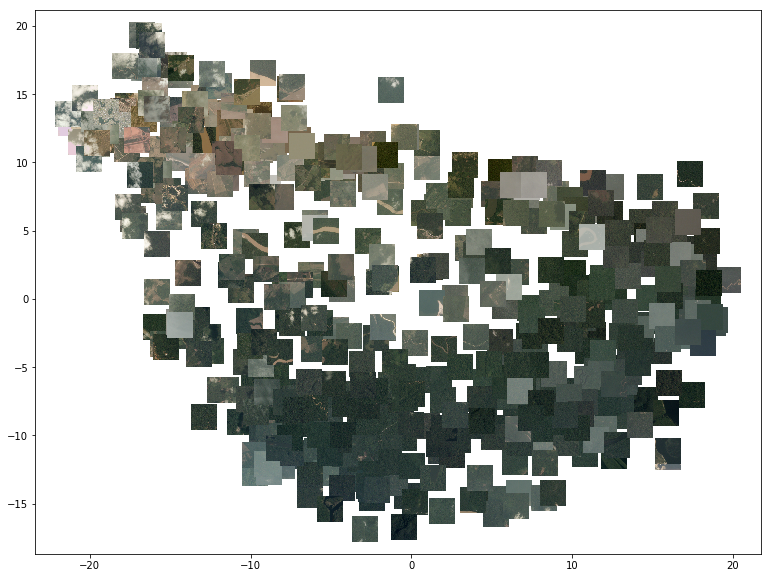

In [53]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

nimgs = 500
plt.figure(figsize=(13,10))
imscatter(tsne[0:nimgs,0], tsne[0:nimgs,1], [plt.imread(image_paths[i]) for i in range(nimgs)])

In [57]:
import seaborn as sns
mndvis = np.nan_to_num([ndvi.mean() for ndvi in ndvis])
plt.figure(figsize=(12,8))
sns.distplot(mndvis)
plt.title('distribution of mean NDVIs')

NameError: name 'ndvis' is not defined

In [58]:
plt.imshow?